In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"



import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



[cuda(id=0)]
gpu
[cuda(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [2]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    6907,
    [
        Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)





R (6907, 60, 3)
Z (6907, 60)
N (6907,)
D (6907,)
com (6907, 3)
Dxyz (6907, 3)
mono (6907, 60, 1)
esp (6907, 3200)
id (6907,)
n_grid (6907,)
vdw_surface (6907, 3200, 3)
n_failed: 286
0 6621
creating_mask
6621


In [3]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [4]:
len(valid_batches)

6621

In [34]:
N = 30
random_ids = [random.randint(0, len(valid_batches)) for _ in range(N)]

In [35]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")
p = ddir / "runs10/20240923-175645dcm-4-espw-10000.0-restart-False/best_10000.0_params.pkl"

p = ddir / "runs10/20240924-102905dcm-2-espw-10000.0-restart-True/best_10000.0_params.pkl"
model, params = create_model_and_params(p)

{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 2.0}


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:56<00:00,  1.89s/it]


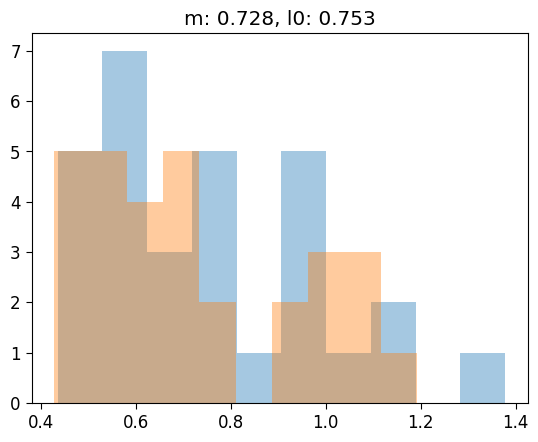

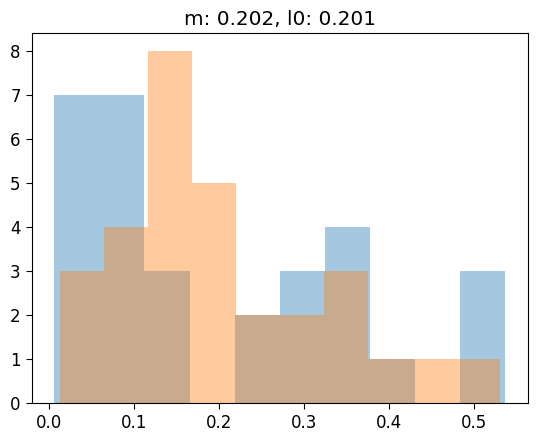

In [36]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(random_ids):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=False,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [37]:
df_ = pd.DataFrame({"i": indexes, "m": m.flatten(), "l0": l0.flatten()})
df_["dif"] = df_["m"] - df_["l0"]
bad = list(df_[df_["dif"] > .1]["i"])

  0%|                                                                                                        | 0/6 [00:00<?, ?it/s]

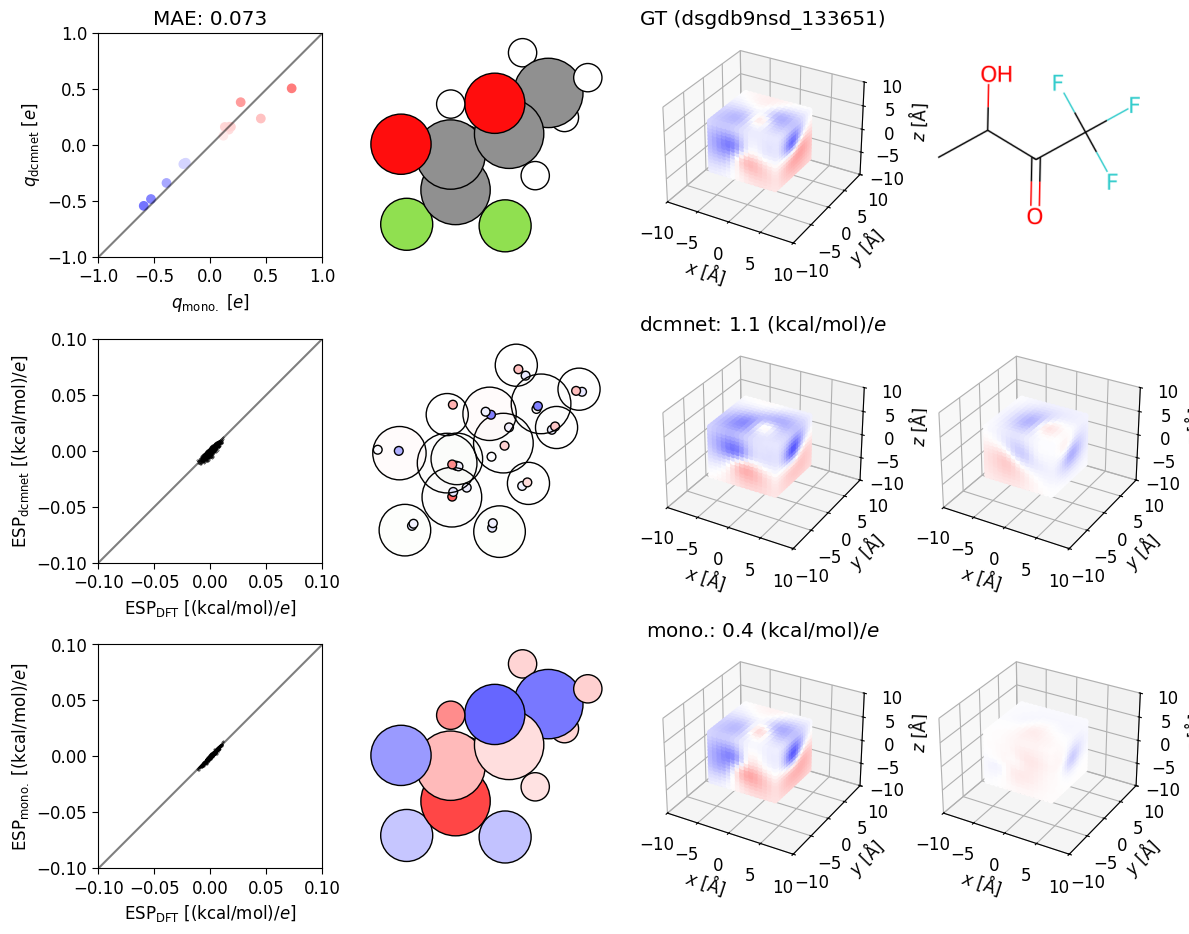

 17%|████████████████                                                                                | 1/6 [00:08<00:40,  8.04s/it]

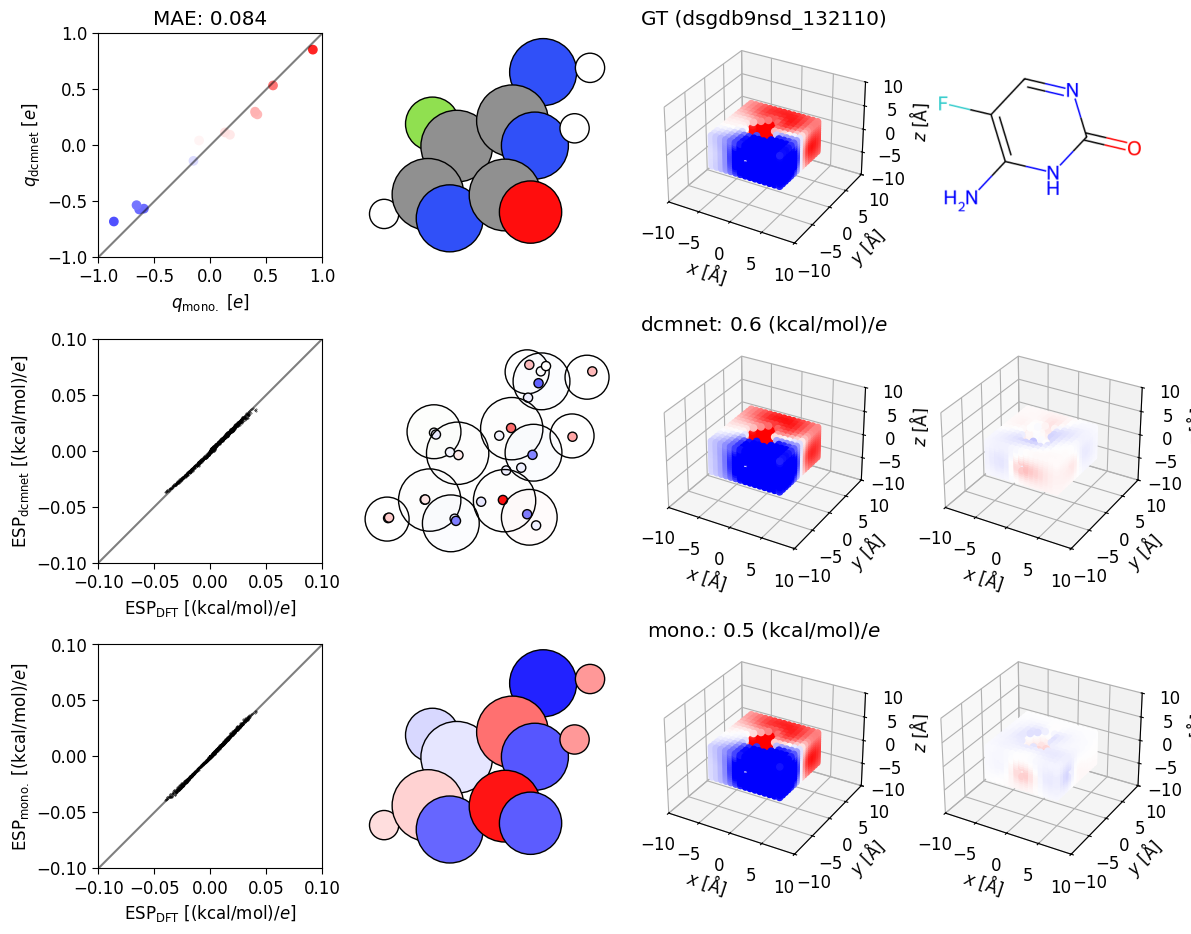

 33%|████████████████████████████████                                                                | 2/6 [00:15<00:31,  7.95s/it]

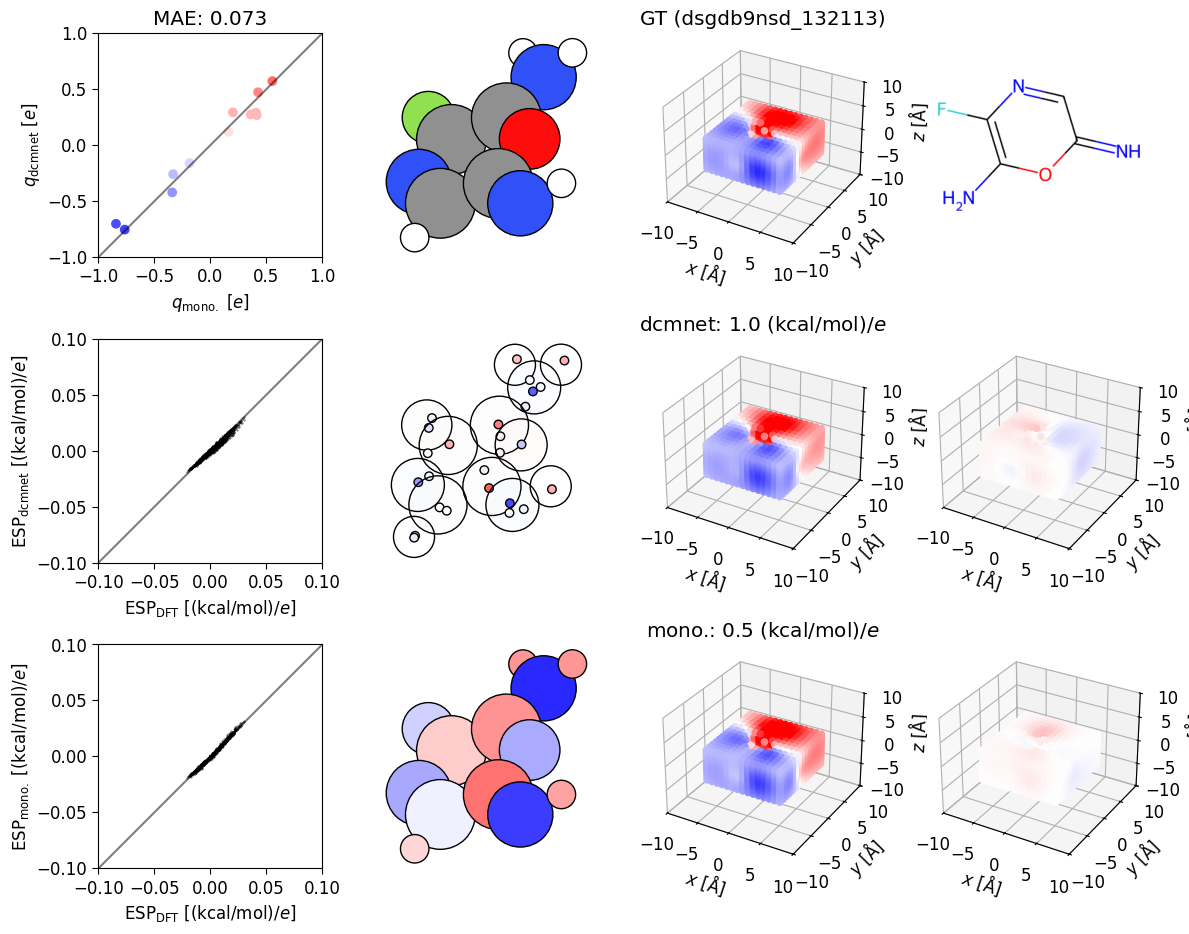

 50%|████████████████████████████████████████████████                                                | 3/6 [00:23<00:23,  7.88s/it]

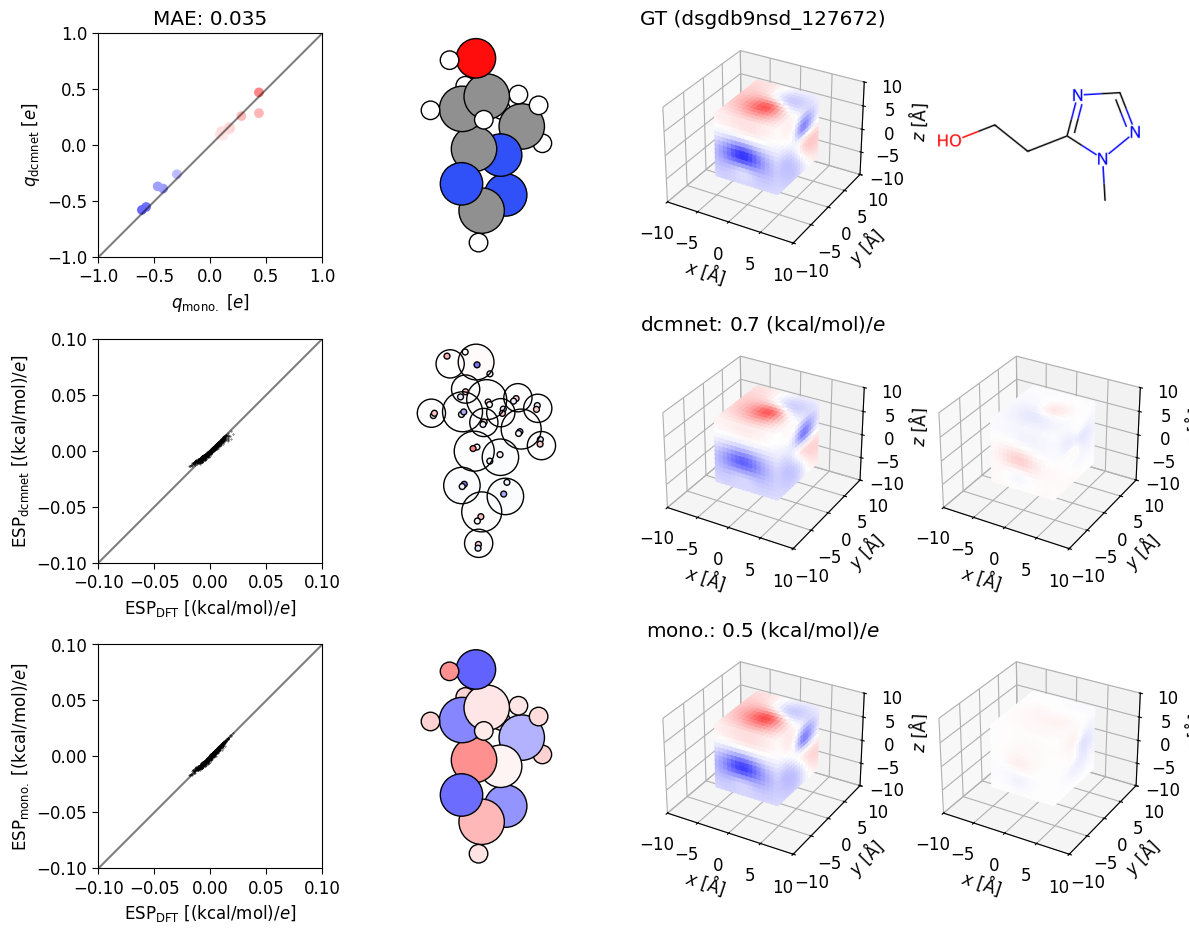

 67%|████████████████████████████████████████████████████████████████                                | 4/6 [00:32<00:16,  8.27s/it]

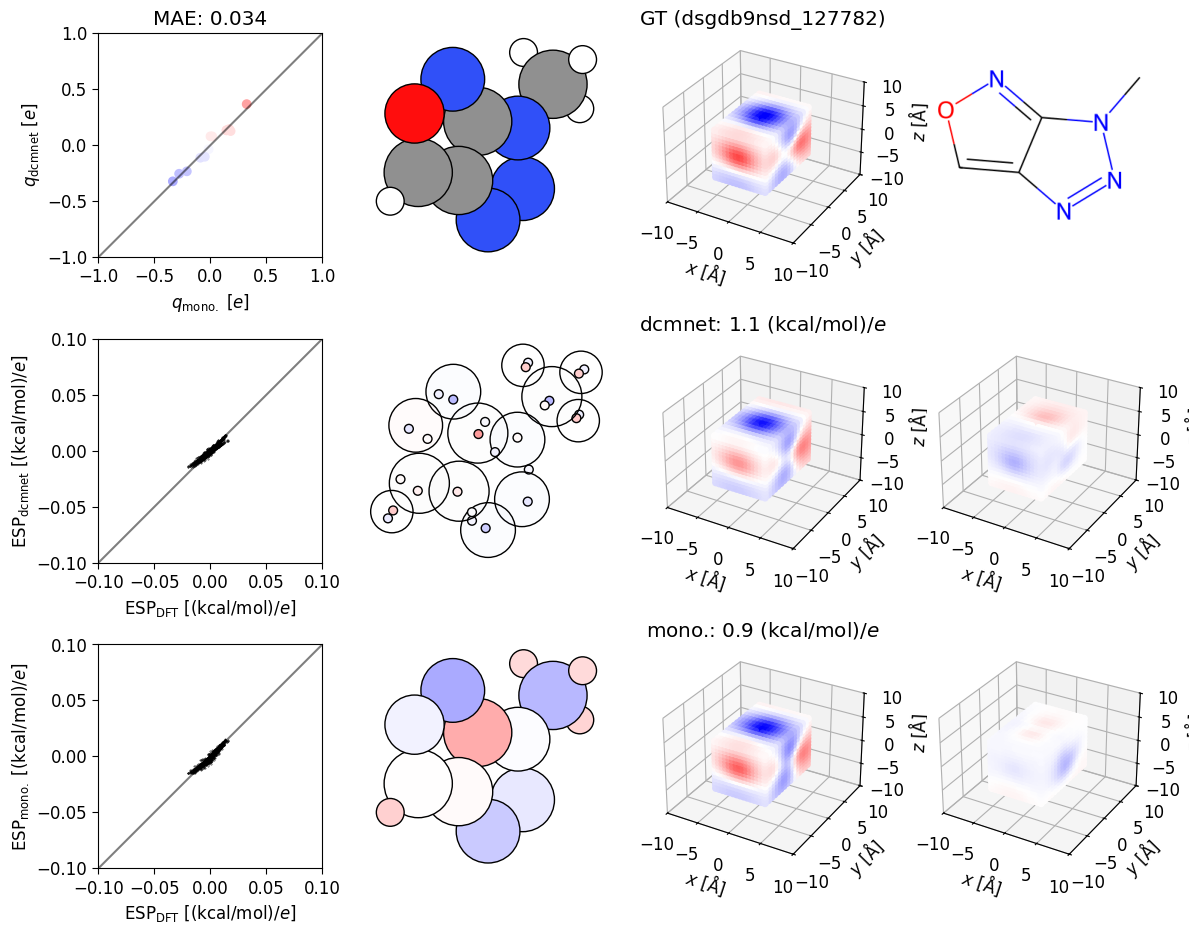

 83%|████████████████████████████████████████████████████████████████████████████████                | 5/6 [00:40<00:08,  8.15s/it]

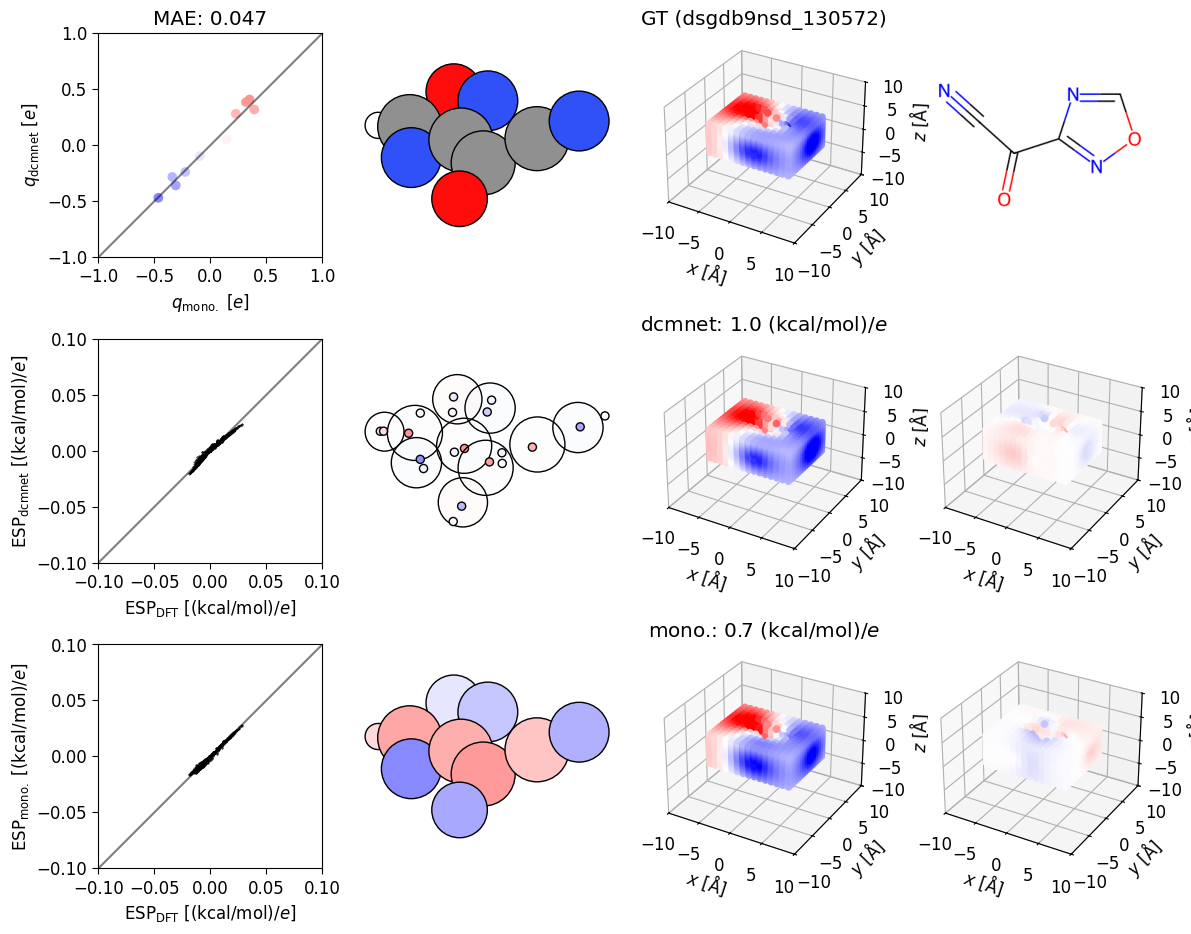

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:47<00:00,  7.98s/it]


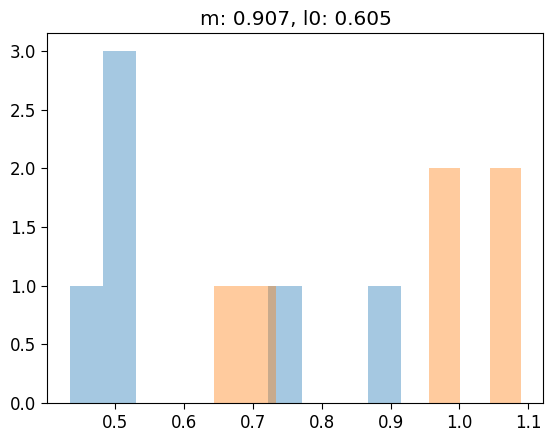

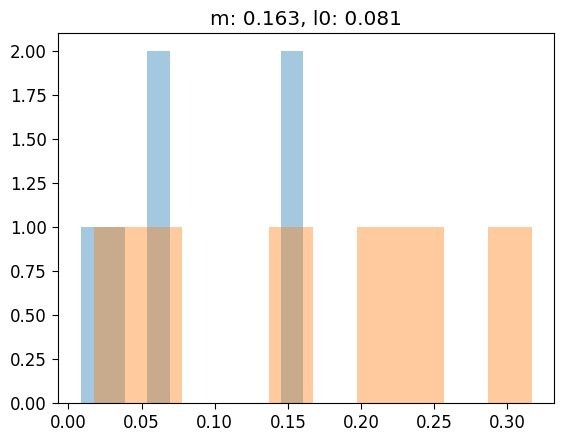

In [38]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(bad):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()